In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utility Function

In [2]:
def convolve(image, kernel):
    """
    Convolve an image with a given kernel.
    :param image: Input 2D numpy array (grayscale image)
    :param kernel: 2D numpy array (filter kernel)
    :return: Convolved image
    """
    m, n = kernel.shape
    pad_h = m // 2
    pad_w = n // 2
    # Pad the image to handle borders
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)

    # Slide the kernel over every pixel in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i + m, j:j + n]
            output[i, j] = np.sum(region * kernel)
    return output

In [3]:
def gaussian_kernel(size, sigma=1):
    """
    Generate a (size x size) Gaussian kernel.
    :param size: Kernel size (must be odd)
    :param sigma: Standard deviation of the Gaussian distribution
    :return: Gaussian kernel as a 2D numpy array
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(- (xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

In [4]:
def sobel_filters(img):
    """
    Compute the gradient intensity and direction of an image using Sobel filters.
    :param img: Input smoothed image (2D numpy array)
    :return: Gradient magnitude and direction (in radians)
    """
    # Sobel kernels for horizontal and vertical gradients
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Ky = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]])

    # Compute gradients along x and y directions
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)

    # Compute gradient magnitude and angle
    G = np.hypot(Ix, Iy)
    theta = np.arctan2(Iy, Ix)

    return G, theta

In [5]:
def non_max_suppression(grad, theta):
    """
    Thin the edges by suppressing non-maximum pixels in the gradient direction.
    :param grad: Gradient magnitude image
    :param theta: Gradient direction image (in radians)
    :return: Image after non-maximum suppression
    """
    M, N = grad.shape
    Z = np.zeros((M, N), dtype=np.float32)
    # Convert angles from radians to degrees and adjust negative angles
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = 255
                r = 255
                # Determine which neighboring pixels to compare with
                # Angle 0 (0°) or 180°
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = grad[i, j + 1]
                    r = grad[i, j - 1]
                # Angle 45°
                elif (22.5 <= angle[i, j] < 67.5):
                    q = grad[i + 1, j - 1]
                    r = grad[i - 1, j + 1]
                # Angle 90°
                elif (67.5 <= angle[i, j] < 112.5):
                    q = grad[i + 1, j]
                    r = grad[i - 1, j]
                # Angle 135°
                elif (112.5 <= angle[i, j] < 157.5):
                    q = grad[i - 1, j - 1]
                    r = grad[i + 1, j + 1]

                if (grad[i, j] >= q) and (grad[i, j] >= r):
                    Z[i, j] = grad[i, j]
                else:
                    Z[i, j] = 0
            except IndexError:
                pass
    return Z

In [6]:
def threshold(img, low_ratio, high_ratio):
    """
    Apply double thresholding to the non-max suppressed image.
    :param img: Image after non-max suppression
    :param low_ratio: Lower ratio to determine the low threshold
    :param high_ratio: Higher ratio to determine the high threshold
    :return: Thresholded image, and values for weak and strong pixel intensities
    """
    highThreshold = img.max() * high_ratio
    lowThreshold = highThreshold * low_ratio

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong = 255
    weak = 75  # Arbitrary value for weak pixels

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img >= lowThreshold) & (img < highThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

In [7]:
def hysteresis(img, weak, strong=255):
    """
    Track edges by hysteresis: keep weak pixels that are connected to strong pixels.
    :param img: Double thresholded image
    :param weak: Value for weak pixels
    :param strong: Value for strong pixels (default 255)
    :return: Final edge-detected image after hysteresis
    """
    M, N = img.shape
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if img[i, j] == weak:
                # Check 8-connected neighborhood
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

# Canny Edge Detection Pipeline

In [16]:
def canny_edge_detection(image, sigma=2.0, low_ratio=0.1, high_ratio=0.3):
    """
    Perform Canny edge detection, returning intermediate results.
    :param image: Grayscale image as a 2D numpy array.
    :param sigma: Standard deviation for Gaussian filter (increased to 2.0).
    :param low_ratio: Lower threshold ratio (increased to 0.1).
    :param high_ratio: Higher threshold ratio (increased to 0.3).
    :return: Tuple containing:
             (smoothed image, gradient magnitude, gradient angle,
              non-maximum suppressed image, thresholded image, final edge image)
    """
    # Step 1: Noise Reduction using a Gaussian filter.
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1
    gauss_kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = convolve(image, gauss_kernel).astype(np.float32)  # Keep float32

    # Step 2: Gradient Calculation using Sobel Filters.
    gradient_magnitude, gradient_angle = sobel_filters(smoothed)
    # Optionally ensure float32 for consistency
    gradient_magnitude = gradient_magnitude.astype(np.float32)

    # Step 3: Non-Maximum Suppression
    non_max = non_max_suppression(gradient_magnitude, gradient_angle)
    # Convert for clarity in thresholding
    non_max = non_max.astype(np.float32)

    # Step 4: Double Thresholding
    # Lower the weak pixel value a bit (e.g., from 75 down to 50)
    thresh_img, weak, strong = threshold(non_max, low_ratio, high_ratio)

    # Step 5: Edge Tracking by Hysteresis
    final_edges = hysteresis(thresh_img, weak, strong)
    # Convert final edges to uint8 for display
    final_edges = final_edges.astype(np.uint8)

    return smoothed, gradient_magnitude, gradient_angle, non_max, thresh_img, final_edges

# Execution and Plotting

In [17]:
img_color = cv2.imread('/content/Fig0646(a)(lenna_original_RGB).tif')

img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Apply the custom Canny edge detection and get intermediate results.
smoothed, grad_mag, grad_angle, non_max, thresh_img, edges = canny_edge_detection(
    img_gray,
    sigma=2.0,       # Increased Gaussian smoothing
    low_ratio=0.1,   # Higher lower threshold ratio
    high_ratio=0.3   # Higher upper threshold ratio
)

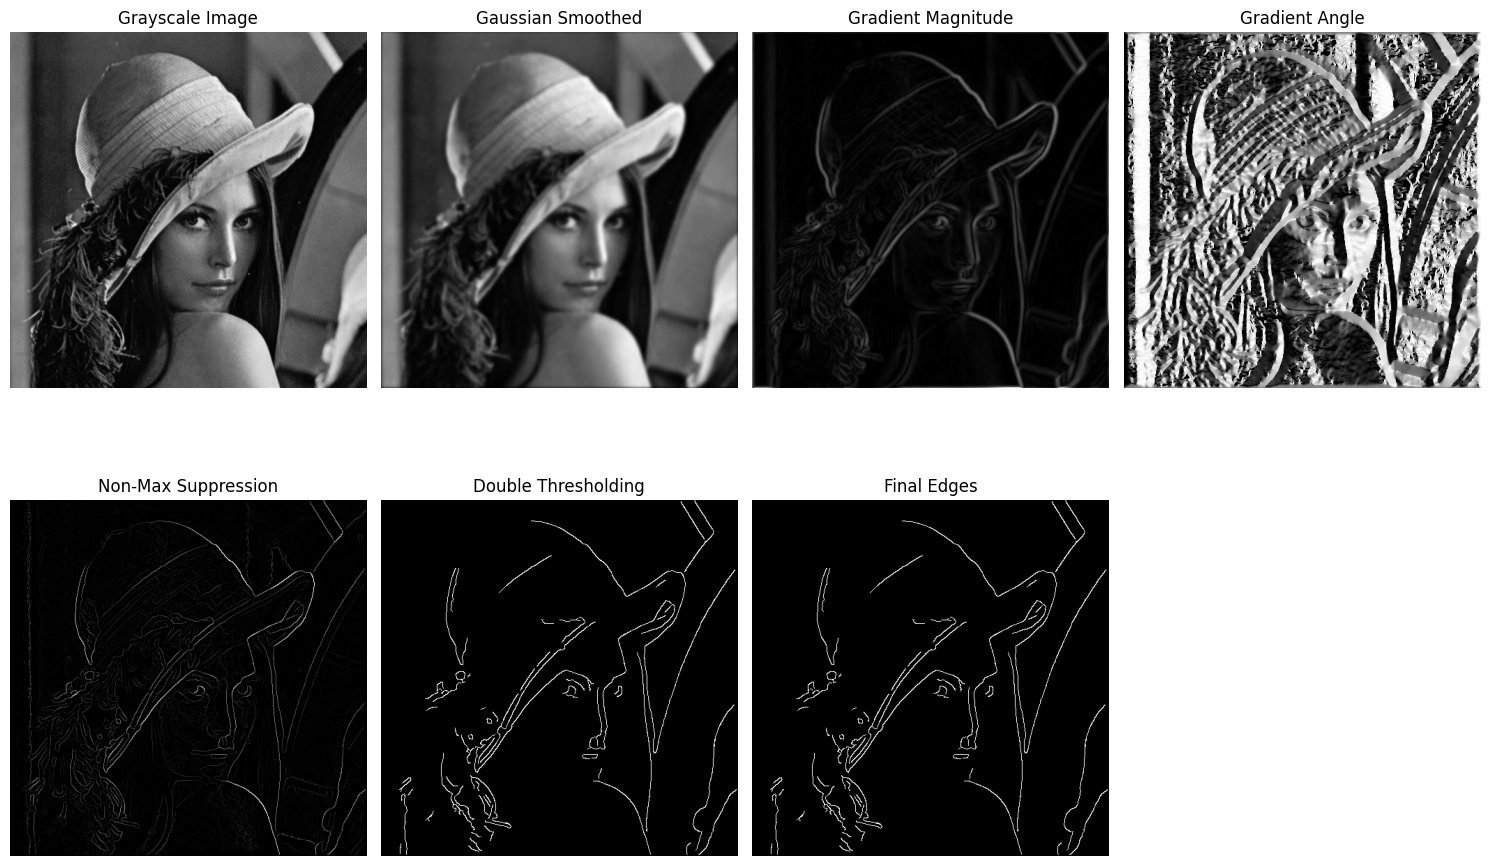

In [18]:
# For visualization purposes, we convert the gradient angle to degrees and normalize it.
grad_angle_deg = np.abs(grad_angle * 180. / np.pi)
grad_angle_norm = (grad_angle_deg / grad_angle_deg.max() * 255).astype(np.uint8)

# Create a figure with subplots.
plt.figure(figsize=(15, 10))

# 1. Original Grayscale Image
plt.subplot(2, 4, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# 2. Smoothed Image
plt.subplot(2, 4, 2)
plt.imshow(smoothed, cmap='gray')
plt.title('Gaussian Smoothed')
plt.axis('off')

# 3. Gradient Magnitude
plt.subplot(2, 4, 3)
plt.imshow(grad_mag, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

# 4. Gradient Angle (Normalized)
plt.subplot(2, 4, 4)
plt.imshow(grad_angle_norm, cmap='gray')
plt.title('Gradient Angle')
plt.axis('off')

# 5. Non-Maximum Suppression
plt.subplot(2, 4, 5)
plt.imshow(non_max, cmap='gray')
plt.title('Non-Max Suppression')
plt.axis('off')

# 6. Double Thresholding Result
plt.subplot(2, 4, 6)
plt.imshow(thresh_img, cmap='gray')
plt.title('Double Thresholding')
plt.axis('off')

# 7. Final Edge Detection (Hysteresis)
plt.subplot(2, 4, 7)
plt.imshow(edges, cmap='gray')
plt.title('Final Edges')
plt.axis('off')

plt.tight_layout()
plt.show()